In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import datetime
import os
import xarray as xr
from dateutil.relativedelta import relativedelta

from utils import normalize

from mod_moving_mnist import ModMovingMNIST
from mpnnlstm import NextFramePredictor

/Users/zach/opt/miniconda3/envs/mpnnlstm/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = xr.open_zarr('data/era5_hb_daily.zarr')
mask = np.isnan(ds.siconc.isel(time=0)).values

/Users/zach/opt/miniconda3/envs/mpnnlstm/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [10]:
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# Number of frames to read as input
input_timesteps = 3
output_timesteps= 1

def xarray_to_x_y(ds, start_date, end_date, input_timesteps, output_timesteps, coarsen=0):
    ds = ds.sel(time=slice(start_date, end_date))
    ds = (ds - ds.min()) / (ds.max() - ds.min())

    if coarsen != 0:
        ds = ds.coarsen(latitude=coarsen, longitude=coarsen, boundary='trim').mean()
    num_samples = ds.time.size-output_timesteps-input_timesteps
    i = 0
    x = np.ndarray((num_samples, input_timesteps, ds.latitude.size, ds.longitude.size, len(ds.data_vars)))
    y = np.ndarray((num_samples, output_timesteps, ds.latitude.size, ds.longitude.size, len(ds.data_vars)))
    while i + output_timesteps + input_timesteps < ds.time.size:
        x[i] = np.moveaxis(np.nan_to_num(ds.isel(time=slice(i, i+input_timesteps)).to_array().to_numpy()), 0, -1)
        y[i] = np.moveaxis(np.nan_to_num(ds.isel(time=slice(i+input_timesteps, i+input_timesteps+output_timesteps)).to_array().to_numpy()), 0, -1)
        i += 1

    return x, y

def xarray_to_y(ds, start_date, end_date, input_timesteps, output_timesteps, coarsen=0):
    ds = ds.sel(time=slice(start_date, end_date))
    ds = (ds - ds.min()) / (ds.max() - ds.min())

    if coarsen != 0:
        ds = ds.coarsen(latitude=coarsen, longitude=coarsen, boundary='trim').mean()
    num_samples = ds.time.size-output_timesteps-input_timesteps
    i = 0
    y = np.ndarray((num_samples, output_timesteps, ds.latitude.size, ds.longitude.size, len(ds.data_vars)))
    while i + output_timesteps + input_timesteps < ds.time.size:
        y[i] = np.moveaxis(np.nan_to_num(ds.isel(time=slice(i+input_timesteps, i+input_timesteps+output_timesteps)).to_array().to_numpy()), 0, -1)
        i += 1

    return y

coarsen = 0
month = 7
x_vars = ['siconc', 't2m']#, 'v10', 'u10', 'sshf']
training_years = (2010, 2016)

def get_data(month):
    
    x, y = [], []
    for year in range(training_years[0], training_years[1]):
        x_year, y_year = xarray_to_x_y(ds[x_vars], datetime.datetime(year, month, 1)-relativedelta(months=0), datetime.datetime(year, month, 1)+relativedelta(months=1), input_timesteps, output_timesteps, coarsen=coarsen)
        x.append(x_year)
        y.append(y_year)
    x = np.concatenate(x, 0)
    y = np.concatenate(y, 0)

    x_test, y_test = xarray_to_x_y(ds[x_vars], datetime.datetime(training_years[1], month, 1), datetime.datetime(training_years[1], month, 1)+relativedelta(months=1), input_timesteps, output_timesteps, coarsen=coarsen)
    x_val, y_val = xarray_to_x_y(ds[x_vars], datetime.datetime(training_years[1]+1, month, 1), datetime.datetime(training_years[1]+1, month, 1)+relativedelta(months=1), input_timesteps, output_timesteps, coarsen=coarsen)
    
    return (x, y), (x_test, y_test), (x_val, y_val)

In [11]:
model_kwargs = dict(
    hidden_size=128,
    dropout=0.1,
    multi_step_loss=output_timesteps,
    input_timesteps=input_timesteps
    )


for month in range(1, 13):
    
    (x, y), (x_test, y_test), (x_val, y_val) = get_data(month)
    
    experiment_name = f'M{month}_Y{training_years[0]}_Y{training_years[1]}_I{input_timesteps}O{input_timesteps}'
    model = NextFramePredictor(experiment_name=experiment_name, decompose=True, input_features=len(x_vars), integrated_space_time=False, **model_kwargs)
    
    model.set_thresh(0.15)
    model.train(x, y, x_test, y_test, lr=0.01, n_epochs=15, mask=mask)  # Train for 20 epochs
    
    print(model.score(x_val, y_val[:, :1]))
    
    model.loss.to_csv(f'ice_results/loss_{experiment_name}.csv')
    model.save('ice_results')

Epoch 0 train loss: 0.5520, test loss: 0.5108, lr: 0.0100, time_per_epoch: 69.1


Epoch 1 train loss: 0.5319, test loss: 0.5096, lr: 0.0100, time_per_epoch: 65.0


Epoch 2 train loss: 0.5303, test loss: 0.5095, lr: 0.0100, time_per_epoch: 63.6


Epoch 3 train loss: 0.5283, test loss: 0.5089, lr: 0.0100, time_per_epoch: 63.0


Epoch 4 train loss: 0.5266, test loss: 0.5083, lr: 0.0100, time_per_epoch: 62.5


Epoch 5 train loss: 0.5250, test loss: 0.5077, lr: 0.0100, time_per_epoch: 62.1


Epoch 6 train loss: 0.5235, test loss: 0.5073, lr: 0.0100, time_per_epoch: 61.9


Epoch 7 train loss: 0.5222, test loss: 0.5069, lr: 0.0100, time_per_epoch: 61.7


Epoch 8 train loss: 0.5210, test loss: 0.5069, lr: 0.0100, time_per_epoch: 61.7


Epoch 9 train loss: 0.5201, test loss: 0.5062, lr: 0.0095, time_per_epoch: 61.6


Epoch 10 train loss: 0.5193, test loss: 0.5060, lr: 0.0095, time_per_epoch: 61.5


Epoch 11 train loss: 0.5187, test loss: 0.5058, lr: 0.0095, time_per_epoch: 61.4


Epoch 12 train loss: 0.5180, test loss: 0.5056, lr: 0.0095, time_per_epoch: 61.3


Epoch 13 train loss: 0.5175, test loss: 0.5053, lr: 0.0095, time_per_epoch: 61.3


Epoch 14 train loss: 0.5170, test loss: 0.5051, lr: 0.0095, time_per_epoch: 61.3
Finished in 15.320941245555877 minutes
tensor(0.5122)


Epoch 0 train loss: 0.5372, test loss: 0.4887, lr: 0.0100, time_per_epoch: 62.6


Epoch 1 train loss: 0.5025, test loss: 0.4887, lr: 0.0100, time_per_epoch: 58.8


Epoch 2 train loss: 0.5024, test loss: 0.4883, lr: 0.0100, time_per_epoch: 57.8


Epoch 3 train loss: 0.5021, test loss: 0.4888, lr: 0.0100, time_per_epoch: 57.2


Epoch 4 train loss: 0.5020, test loss: 0.4882, lr: 0.0100, time_per_epoch: 56.8


Epoch 5 train loss: 0.5020, test loss: 0.4882, lr: 0.0100, time_per_epoch: 56.5


Epoch 6 train loss: 0.5017, test loss: 0.4883, lr: 0.0100, time_per_epoch: 56.4


Epoch 7 train loss: 0.5016, test loss: 0.4879, lr: 0.0100, time_per_epoch: 56.2


Epoch 8 train loss: 0.5016, test loss: 0.4877, lr: 0.0100, time_per_epoch: 56.1


Epoch 9 train loss: 0.5013, test loss: 0.4877, lr: 0.0095, time_per_epoch: 56.0


Epoch 10 train loss: 0.5012, test loss: 0.4877, lr: 0.0095, time_per_epoch: 55.9


Epoch 11 train loss: 0.5011, test loss: 0.4874, lr: 0.0095, time_per_epoch: 55.9


Epoch 12 train loss: 0.5009, test loss: 0.4876, lr: 0.0095, time_per_epoch: 55.8


Epoch 13 train loss: 0.5007, test loss: 0.4871, lr: 0.0095, time_per_epoch: 55.7


Epoch 14 train loss: 0.5004, test loss: 0.4871, lr: 0.0095, time_per_epoch: 55.7
Finished in 13.921495683987935 minutes
tensor(0.6928)


Epoch 0 train loss: 0.5150, test loss: 0.4838, lr: 0.0100, time_per_epoch: 68.2


Epoch 1 train loss: 0.4870, test loss: 0.4838, lr: 0.0100, time_per_epoch: 64.6


Epoch 2 train loss: 0.4869, test loss: 0.4839, lr: 0.0100, time_per_epoch: 63.4


Epoch 3 train loss: 0.4868, test loss: 0.4839, lr: 0.0100, time_per_epoch: 62.7


Epoch 4 train loss: 0.4867, test loss: 0.4833, lr: 0.0100, time_per_epoch: 62.3


Epoch 5 train loss: 0.4865, test loss: 0.4832, lr: 0.0100, time_per_epoch: 62.1


Epoch 6 train loss: 0.4864, test loss: 0.4828, lr: 0.0100, time_per_epoch: 62.0


Epoch 7 train loss: 0.4861, test loss: 0.4829, lr: 0.0100, time_per_epoch: 61.8


Epoch 8 train loss: 0.4861, test loss: 0.4827, lr: 0.0100, time_per_epoch: 61.7


Epoch 9 train loss: 0.4859, test loss: 0.4830, lr: 0.0095, time_per_epoch: 61.7


Epoch 10 train loss: 0.4859, test loss: 0.4823, lr: 0.0095, time_per_epoch: 61.6


Epoch 11 train loss: 0.4856, test loss: 0.4824, lr: 0.0095, time_per_epoch: 61.5


Epoch 12 train loss: 0.4853, test loss: 0.4820, lr: 0.0095, time_per_epoch: 61.5


Epoch 13 train loss: 0.4853, test loss: 0.4820, lr: 0.0095, time_per_epoch: 61.5


Epoch 14 train loss: 0.4851, test loss: 0.4818, lr: 0.0095, time_per_epoch: 61.4
Finished in 15.355829318364462 minutes
tensor(0.6855)


Epoch 0 train loss: 0.5282, test loss: 0.4991, lr: 0.0100, time_per_epoch: 64.7


Epoch 1 train loss: 0.5036, test loss: 0.4982, lr: 0.0100, time_per_epoch: 61.6


Epoch 2 train loss: 0.5029, test loss: 0.4977, lr: 0.0100, time_per_epoch: 60.7


Epoch 3 train loss: 0.5021, test loss: 0.4972, lr: 0.0100, time_per_epoch: 60.1


Epoch 4 train loss: 0.5016, test loss: 0.4963, lr: 0.0100, time_per_epoch: 59.8


Epoch 5 train loss: 0.5008, test loss: 0.4949, lr: 0.0100, time_per_epoch: 59.6


Epoch 6 train loss: 0.5000, test loss: 0.4947, lr: 0.0100, time_per_epoch: 59.5


Epoch 7 train loss: 0.4994, test loss: 0.4939, lr: 0.0100, time_per_epoch: 59.4


Epoch 8 train loss: 0.4986, test loss: 0.4930, lr: 0.0100, time_per_epoch: 59.4


Epoch 9 train loss: 0.4978, test loss: 0.4922, lr: 0.0095, time_per_epoch: 59.3


Epoch 10 train loss: 0.4973, test loss: 0.4913, lr: 0.0095, time_per_epoch: 59.3


Epoch 11 train loss: 0.4963, test loss: 0.4903, lr: 0.0095, time_per_epoch: 59.2


Epoch 12 train loss: 0.4959, test loss: 0.4894, lr: 0.0095, time_per_epoch: 59.2


Epoch 13 train loss: 0.4950, test loss: 0.4885, lr: 0.0095, time_per_epoch: 59.2


Epoch 14 train loss: 0.4946, test loss: 0.4879, lr: 0.0095, time_per_epoch: 59.1
Finished in 14.784253470102946 minutes
tensor(0.5851)


Epoch 0 train loss: 0.5925, test loss: 0.5508, lr: 0.0100, time_per_epoch: 68.1


Epoch 1 train loss: 0.5704, test loss: 0.5332, lr: 0.0100, time_per_epoch: 64.5


Epoch 2 train loss: 0.5587, test loss: 0.5198, lr: 0.0100, time_per_epoch: 63.4


Epoch 3 train loss: 0.5498, test loss: 0.5098, lr: 0.0100, time_per_epoch: 62.8


Epoch 4 train loss: 0.5436, test loss: 0.5035, lr: 0.0100, time_per_epoch: 62.4


Epoch 5 train loss: 0.5399, test loss: 0.4994, lr: 0.0100, time_per_epoch: 62.3


Epoch 6 train loss: 0.5378, test loss: 0.4971, lr: 0.0100, time_per_epoch: 62.1


Epoch 7 train loss: 0.5366, test loss: 0.4957, lr: 0.0100, time_per_epoch: 61.9


Epoch 8 train loss: 0.5361, test loss: 0.4952, lr: 0.0100, time_per_epoch: 61.8


Epoch 9 train loss: 0.5357, test loss: 0.4941, lr: 0.0095, time_per_epoch: 61.8


Epoch 10 train loss: 0.5354, test loss: 0.4937, lr: 0.0095, time_per_epoch: 61.7


Epoch 11 train loss: 0.5354, test loss: 0.4938, lr: 0.0095, time_per_epoch: 61.6


Epoch 12 train loss: 0.5353, test loss: 0.4936, lr: 0.0095, time_per_epoch: 61.6


Epoch 13 train loss: 0.5352, test loss: 0.4933, lr: 0.0095, time_per_epoch: 61.6


Epoch 14 train loss: 0.5352, test loss: 0.4930, lr: 0.0095, time_per_epoch: 61.5
Finished in 15.376265335083009 minutes
tensor(0.4636)


Epoch 0 train loss: 0.6436, test loss: 0.5979, lr: 0.0100, time_per_epoch: 63.2


Epoch 1 train loss: 0.5724, test loss: 0.5607, lr: 0.0100, time_per_epoch: 60.5


Epoch 2 train loss: 0.5456, test loss: 0.5545, lr: 0.0100, time_per_epoch: 59.4


Epoch 3 train loss: 0.5413, test loss: 0.5538, lr: 0.0100, time_per_epoch: 59.1


Epoch 4 train loss: 0.5402, test loss: 0.5537, lr: 0.0100, time_per_epoch: 58.8


Epoch 5 train loss: 0.5399, test loss: 0.5540, lr: 0.0100, time_per_epoch: 58.7


Epoch 6 train loss: 0.5398, test loss: 0.5537, lr: 0.0100, time_per_epoch: 58.6


Epoch 7 train loss: 0.5397, test loss: 0.5535, lr: 0.0100, time_per_epoch: 58.5


Epoch 8 train loss: 0.5396, test loss: 0.5538, lr: 0.0100, time_per_epoch: 58.5


Epoch 9 train loss: 0.5396, test loss: 0.5536, lr: 0.0095, time_per_epoch: 58.5


Epoch 10 train loss: 0.5395, test loss: 0.5533, lr: 0.0095, time_per_epoch: 58.4


Epoch 11 train loss: 0.5394, test loss: 0.5534, lr: 0.0095, time_per_epoch: 58.4


Epoch 12 train loss: 0.5393, test loss: 0.5534, lr: 0.0095, time_per_epoch: 58.4


Epoch 13 train loss: 0.5392, test loss: 0.5533, lr: 0.0095, time_per_epoch: 58.4


Epoch 14 train loss: 0.5394, test loss: 0.5535, lr: 0.0095, time_per_epoch: 58.3
Finished in 14.583656418323518 minutes
tensor(0.4199)


Epoch 0 train loss: 0.5570, test loss: 0.5299, lr: 0.0100, time_per_epoch: 55.2


Epoch 1 train loss: 0.4893, test loss: 0.4974, lr: 0.0100, time_per_epoch: 51.3


Epoch 2 train loss: 0.4583, test loss: 0.4750, lr: 0.0100, time_per_epoch: 49.8


Epoch 3 train loss: 0.4430, test loss: 0.4684, lr: 0.0100, time_per_epoch: 49.2


Epoch 4 train loss: 0.4385, test loss: 0.4677, lr: 0.0100, time_per_epoch: 48.6


Epoch 5 train loss: 0.4376, test loss: 0.4674, lr: 0.0100, time_per_epoch: 48.2


Epoch 6 train loss: 0.4366, test loss: 0.4663, lr: 0.0100, time_per_epoch: 48.0


Epoch 7 train loss: 0.4363, test loss: 0.4666, lr: 0.0100, time_per_epoch: 47.8


Epoch 8 train loss: 0.4358, test loss: 0.4661, lr: 0.0100, time_per_epoch: 47.6


Epoch 9 train loss: 0.4353, test loss: 0.4658, lr: 0.0095, time_per_epoch: 47.5


Epoch 10 train loss: 0.4351, test loss: 0.4656, lr: 0.0095, time_per_epoch: 47.4


Epoch 11 train loss: 0.4347, test loss: 0.4657, lr: 0.0095, time_per_epoch: 47.4


Epoch 12 train loss: 0.4347, test loss: 0.4651, lr: 0.0095, time_per_epoch: 47.3


Epoch 13 train loss: 0.4341, test loss: 0.4649, lr: 0.0095, time_per_epoch: 47.4


Epoch 14 train loss: 0.4339, test loss: 0.4652, lr: 0.0095, time_per_epoch: 47.3
Finished in 11.833903952439625 minutes
tensor(0.3483)


Epoch 0 train loss: 0.4865, test loss: 0.4345, lr: 0.0100, time_per_epoch: 50.6


Epoch 1 train loss: 0.4150, test loss: 0.4316, lr: 0.0100, time_per_epoch: 46.1


Epoch 2 train loss: 0.4093, test loss: 0.4284, lr: 0.0100, time_per_epoch: 44.8


Epoch 3 train loss: 0.4050, test loss: 0.4234, lr: 0.0100, time_per_epoch: 44.0


Epoch 4 train loss: 0.4006, test loss: 0.4186, lr: 0.0100, time_per_epoch: 43.6


Epoch 5 train loss: 0.3966, test loss: 0.4140, lr: 0.0100, time_per_epoch: 43.5


Epoch 6 train loss: 0.3931, test loss: 0.4108, lr: 0.0100, time_per_epoch: 43.2


Epoch 7 train loss: 0.3901, test loss: 0.4079, lr: 0.0100, time_per_epoch: 43.2


Epoch 8 train loss: 0.3879, test loss: 0.4063, lr: 0.0100, time_per_epoch: 43.0


Epoch 9 train loss: 0.3859, test loss: 0.4042, lr: 0.0095, time_per_epoch: 42.9


Epoch 10 train loss: 0.3847, test loss: 0.4036, lr: 0.0095, time_per_epoch: 42.9


Epoch 11 train loss: 0.3832, test loss: 0.4024, lr: 0.0095, time_per_epoch: 42.9


Epoch 12 train loss: 0.3823, test loss: 0.4024, lr: 0.0095, time_per_epoch: 42.8


Epoch 13 train loss: 0.3821, test loss: 0.4027, lr: 0.0095, time_per_epoch: 42.8


Epoch 14 train loss: 0.3815, test loss: 0.4017, lr: 0.0095, time_per_epoch: 42.8
Finished in 10.700895297527314 minutes
tensor(0.3447)


Epoch 0 train loss: 0.4915, test loss: 0.4352, lr: 0.0100, time_per_epoch: 48.5


Epoch 1 train loss: 0.4069, test loss: 0.4340, lr: 0.0100, time_per_epoch: 44.3


Epoch 2 train loss: 0.4021, test loss: 0.4345, lr: 0.0100, time_per_epoch: 43.2


Epoch 3 train loss: 0.4010, test loss: 0.4347, lr: 0.0100, time_per_epoch: 42.7


Epoch 4 train loss: 0.4004, test loss: 0.4343, lr: 0.0100, time_per_epoch: 42.0


Epoch 5 train loss: 0.3998, test loss: 0.4336, lr: 0.0100, time_per_epoch: 41.6


Epoch 6 train loss: 0.3991, test loss: 0.4326, lr: 0.0100, time_per_epoch: 41.4


Epoch 7 train loss: 0.3988, test loss: 0.4316, lr: 0.0100, time_per_epoch: 41.2


Epoch 8 train loss: 0.3978, test loss: 0.4299, lr: 0.0100, time_per_epoch: 41.0


Epoch 9 train loss: 0.3973, test loss: 0.4289, lr: 0.0095, time_per_epoch: 40.9


Epoch 10 train loss: 0.3967, test loss: 0.4277, lr: 0.0095, time_per_epoch: 40.9


Epoch 11 train loss: 0.3963, test loss: 0.4261, lr: 0.0095, time_per_epoch: 40.7


Epoch 12 train loss: 0.3955, test loss: 0.4250, lr: 0.0095, time_per_epoch: 40.6


Epoch 13 train loss: 0.3952, test loss: 0.4237, lr: 0.0095, time_per_epoch: 40.6


Epoch 14 train loss: 0.3947, test loss: 0.4231, lr: 0.0095, time_per_epoch: 40.5
Finished in 10.13435165087382 minutes
tensor(0.3540)


Epoch 0 train loss: 0.5077, test loss: 0.4723, lr: 0.0100, time_per_epoch: 49.2


Epoch 1 train loss: 0.4419, test loss: 0.4616, lr: 0.0100, time_per_epoch: 45.3


Epoch 2 train loss: 0.4285, test loss: 0.4523, lr: 0.0100, time_per_epoch: 44.0


Epoch 3 train loss: 0.4185, test loss: 0.4444, lr: 0.0100, time_per_epoch: 43.3


Epoch 4 train loss: 0.4100, test loss: 0.4380, lr: 0.0100, time_per_epoch: 42.7


Epoch 5 train loss: 0.4038, test loss: 0.4331, lr: 0.0100, time_per_epoch: 42.5


Epoch 6 train loss: 0.3998, test loss: 0.4301, lr: 0.0100, time_per_epoch: 42.4


Epoch 7 train loss: 0.3977, test loss: 0.4298, lr: 0.0100, time_per_epoch: 42.3


Epoch 8 train loss: 0.3968, test loss: 0.4299, lr: 0.0100, time_per_epoch: 42.1


Epoch 9 train loss: 0.3962, test loss: 0.4290, lr: 0.0095, time_per_epoch: 41.9


Epoch 10 train loss: 0.3960, test loss: 0.4287, lr: 0.0095, time_per_epoch: 41.8


Epoch 11 train loss: 0.3957, test loss: 0.4284, lr: 0.0095, time_per_epoch: 41.7


Epoch 12 train loss: 0.3955, test loss: 0.4282, lr: 0.0095, time_per_epoch: 41.8


Epoch 13 train loss: 0.3952, test loss: 0.4280, lr: 0.0095, time_per_epoch: 41.7


Epoch 14 train loss: 0.3948, test loss: 0.4279, lr: 0.0095, time_per_epoch: 41.7
Finished in 10.42350298166275 minutes
tensor(0.3565)


Epoch 0 train loss: 0.5993, test loss: 0.5456, lr: 0.0100, time_per_epoch: 52.2


Epoch 1 train loss: 0.4900, test loss: 0.4803, lr: 0.0100, time_per_epoch: 47.1


Epoch 2 train loss: 0.4598, test loss: 0.4721, lr: 0.0100, time_per_epoch: 45.9


Epoch 3 train loss: 0.4556, test loss: 0.4703, lr: 0.0100, time_per_epoch: 45.2


Epoch 4 train loss: 0.4546, test loss: 0.4693, lr: 0.0100, time_per_epoch: 45.0


Epoch 5 train loss: 0.4538, test loss: 0.4691, lr: 0.0100, time_per_epoch: 44.6


Epoch 6 train loss: 0.4530, test loss: 0.4689, lr: 0.0100, time_per_epoch: 44.5


Epoch 7 train loss: 0.4525, test loss: 0.4681, lr: 0.0100, time_per_epoch: 44.3


Epoch 8 train loss: 0.4514, test loss: 0.4684, lr: 0.0100, time_per_epoch: 44.1


Epoch 9 train loss: 0.4509, test loss: 0.4677, lr: 0.0095, time_per_epoch: 43.9


Epoch 10 train loss: 0.4503, test loss: 0.4669, lr: 0.0095, time_per_epoch: 44.0


Epoch 11 train loss: 0.4498, test loss: 0.4668, lr: 0.0095, time_per_epoch: 43.9


Epoch 12 train loss: 0.4494, test loss: 0.4661, lr: 0.0095, time_per_epoch: 43.7


Epoch 13 train loss: 0.4492, test loss: 0.4662, lr: 0.0095, time_per_epoch: 43.7


Epoch 14 train loss: 0.4488, test loss: 0.4660, lr: 0.0095, time_per_epoch: 43.7
Finished in 10.914825801054636 minutes
tensor(0.3833)


Epoch 0 train loss: 0.6166, test loss: 0.5821, lr: 0.0100, time_per_epoch: 73.5


Epoch 1 train loss: 0.5785, test loss: 0.5450, lr: 0.0100, time_per_epoch: 66.5


Epoch 2 train loss: 0.5533, test loss: 0.5302, lr: 0.0100, time_per_epoch: 64.0


Epoch 3 train loss: 0.5438, test loss: 0.5252, lr: 0.0100, time_per_epoch: 62.7


Epoch 4 train loss: 0.5407, test loss: 0.5244, lr: 0.0100, time_per_epoch: 61.9


Epoch 5 train loss: 0.5396, test loss: 0.5236, lr: 0.0100, time_per_epoch: 61.4


Epoch 6 train loss: 0.5390, test loss: 0.5235, lr: 0.0100, time_per_epoch: 61.0


Epoch 7 train loss: 0.5388, test loss: 0.5233, lr: 0.0100, time_per_epoch: 60.7


Epoch 8 train loss: 0.5383, test loss: 0.5232, lr: 0.0100, time_per_epoch: 60.5


Epoch 9 train loss: 0.5379, test loss: 0.5227, lr: 0.0095, time_per_epoch: 60.4


Epoch 10 train loss: 0.5377, test loss: 0.5228, lr: 0.0095, time_per_epoch: 60.2


Epoch 11 train loss: 0.5373, test loss: 0.5225, lr: 0.0095, time_per_epoch: 60.1


Epoch 12 train loss: 0.5371, test loss: 0.5223, lr: 0.0095, time_per_epoch: 60.0


Epoch 13 train loss: 0.5369, test loss: 0.5224, lr: 0.0095, time_per_epoch: 59.9


Epoch 14 train loss: 0.5365, test loss: 0.5221, lr: 0.0095, time_per_epoch: 59.9
Finished in 14.966220001379648 minutes
tensor(0.5013)


In [61]:
y_hat = {}
for month in range(1, 13):
    
    x_val, y_val = xarray_to_x_y(ds[x_vars], datetime.datetime(training_years[1]+1, month, 1), datetime.datetime(training_years[1]+1, month, 1)+relativedelta(days=30+input_timesteps), input_timesteps, output_timesteps, coarsen=coarsen)
    
    experiment_name = f'M{month}_Y{training_years[0]}_Y{training_years[1]}_I{input_timesteps}O{input_timesteps}'
    model = NextFramePredictor(experiment_name=experiment_name, decompose=True, input_features=len(x_vars), integrated_space_time=False, **model_kwargs)
    model.set_thresh(0.15)
    model.load(f'ice_results/{experiment_name}.pth')
    
    y_hat[month] = model.predict(x_val, 3)[..., 0]
    print(month, end='\r')

In [76]:
input_timesteps

3

In [99]:
import pandas as pd

ds_pred = []
for month in range(1, 13):
    launchdate = pd.date_range(datetime.datetime(training_years[1]+1, month, 1), datetime.datetime(training_years[1]+1, month, 1)+relativedelta(days=30+input_timesteps))
    timesteps = range(1, 4)
    
    ds_pred.append(xr.DataArray(
        data=y_hat[month],
        dims=["time", "timestep", "x", "y"],
        coords=dict(
            x=range(77),
            y=range(121),
            time=launchdate[input_timesteps:-1],
            timestep=timesteps,
        )))
    
ds_pred = xr.concat(ds_pred, dim='time')

In [116]:
ds_pred.sel(time=slice(*daterange), timestep=timestep)

<xarray.DataArray (time: 32, x: 77, y: 121)>
array([[[0.4738268 , 0.47382361, 0.4738183 , ..., 0.47377527,
         0.47377589, 0.47377458],
        [0.47382906, 0.4738259 , 0.47382072, ..., 0.4737725 ,
         0.47377291, 0.47377172],
        [0.47383136, 0.4738276 , 0.47382206, ..., 0.47376671,
         0.47376701, 0.47376606],
        ...,
        [0.76972884, 0.7696715 , 0.7696048 , ..., 0.77423233,
         0.77493113, 0.77465349],
        [0.47383747, 0.47383007, 0.47382045, ..., 0.77453476,
         0.77496088, 0.77466601],
        [0.4737879 , 0.47378442, 0.47378147, ..., 0.77453935,
         0.77496123, 0.77466995]],

       [[0.47382867, 0.47382578, 0.4738214 , ..., 0.47379303,
         0.47379345, 0.47379154],
        [0.47383082, 0.47382793, 0.47382361, ..., 0.47378725,
         0.47378799, 0.47378671],
        [0.47383276, 0.47382975, 0.47382504, ..., 0.47377688,
         0.4737781 , 0.47377741],
...
        [0.87266326, 0.8726992 , 0.87273562, ..., 0.87848145,
         0.87853861, 0.8783226 ],
        [0.71979749, 0.71979493, 0.71979398, ..., 0.87886047,
         0.87868619, 0.87828588],
        [0.71975362, 0.71974885, 0.71974909, ..., 0.87928432,
         0.87911284, 0.8787185 ]],

       [[0.71978885, 0.71979368, 0.71980387, ..., 0.72021496,
         0.72021466, 0.72021782],
        [0.71978343, 0.71978861, 0.71979916, ..., 0.72021383,
         0.72021359, 0.72021687],
        [0.7197724 , 0.71977741, 0.71978819, ..., 0.72021192,
         0.72021174, 0.72021496],
        ...,
        [0.87266648, 0.87268019, 0.87269104, ..., 0.87733197,
         0.87722802, 0.87686068],
        [0.71979076, 0.71978712, 0.71978503, ..., 0.8776772 ,
         0.87740046, 0.87685394],
        [0.71974266, 0.71973705, 0.7197364 , ..., 0.87805396,
         0.87778276, 0.87724316]]])
Coordinates:
  * x         (x) int64 0 1 2 3 4 5 6 7 8 9 10 ... 67 68 69 70 71 72 73 74 75 76
  * y         (y) int64 0 1 2 3 4 5 6 7 8 ... 113 114 115 116 117 118 119 120
  * time      (time) datetime64[ns] 2017-11-28 2017-11-29 ... 2017-12-29
    timestep  int64 3

In [134]:
for a in ds_pred.time.values:
    print(a)

2017-01-04T00:00:00.000000000
2017-01-05T00:00:00.000000000
2017-01-06T00:00:00.000000000
2017-01-07T00:00:00.000000000
2017-01-08T00:00:00.000000000
2017-01-09T00:00:00.000000000
2017-01-10T00:00:00.000000000
2017-01-11T00:00:00.000000000
2017-01-12T00:00:00.000000000
2017-01-13T00:00:00.000000000
2017-01-14T00:00:00.000000000
2017-01-15T00:00:00.000000000
2017-01-16T00:00:00.000000000
2017-01-17T00:00:00.000000000
2017-01-18T00:00:00.000000000
2017-01-19T00:00:00.000000000
2017-01-20T00:00:00.000000000
2017-01-21T00:00:00.000000000
2017-01-22T00:00:00.000000000
2017-01-23T00:00:00.000000000
2017-01-24T00:00:00.000000000
2017-01-25T00:00:00.000000000
2017-01-26T00:00:00.000000000
2017-01-27T00:00:00.000000000
2017-01-28T00:00:00.000000000
2017-01-29T00:00:00.000000000
2017-01-30T00:00:00.000000000
2017-01-31T00:00:00.000000000
2017-02-01T00:00:00.000000000
2017-02-02T00:00:00.000000000
2017-02-04T00:00:00.000000000
2017-02-05T00:00:00.000000000
2017-02-06T00:00:00.000000000
2017-02-07

In [131]:
# for month in range(2, 13):
#     for timestep in timesteps:
#         first_of_the_month = datetime.datetime(training_years[1]+1, month, 1)
#         daterange = first_of_the_month-relativedelta(days=timestep), first_of_the_month+relativedelta(months=1)-relativedelta(days=timestep)
#         ds_pred.sel(time=slice(*daterange), timestep=timestep)
        
doys = pd.date_range(datetime.datetime(training_years[1]+1, 1, input_timesteps+1), datetime.datetime(training_years[1]+1, 12, 31))

for doy in doys:
    for lead_time in range(input_timesteps):
        ds_pred.sel(time=doy)
        print(doy)

2017-01-04 00:00:00
2017-01-04 00:00:00
2017-01-04 00:00:00
2017-01-05 00:00:00
2017-01-05 00:00:00
2017-01-05 00:00:00
2017-01-06 00:00:00
2017-01-06 00:00:00
2017-01-06 00:00:00
2017-01-07 00:00:00
2017-01-07 00:00:00
2017-01-07 00:00:00
2017-01-08 00:00:00
2017-01-08 00:00:00
2017-01-08 00:00:00
2017-01-09 00:00:00
2017-01-09 00:00:00
2017-01-09 00:00:00
2017-01-10 00:00:00
2017-01-10 00:00:00
2017-01-10 00:00:00
2017-01-11 00:00:00
2017-01-11 00:00:00
2017-01-11 00:00:00
2017-01-12 00:00:00
2017-01-12 00:00:00
2017-01-12 00:00:00
2017-01-13 00:00:00
2017-01-13 00:00:00
2017-01-13 00:00:00
2017-01-14 00:00:00
2017-01-14 00:00:00
2017-01-14 00:00:00
2017-01-15 00:00:00
2017-01-15 00:00:00
2017-01-15 00:00:00
2017-01-16 00:00:00
2017-01-16 00:00:00
2017-01-16 00:00:00
2017-01-17 00:00:00
2017-01-17 00:00:00
2017-01-17 00:00:00
2017-01-18 00:00:00
2017-01-18 00:00:00
2017-01-18 00:00:00
2017-01-19 00:00:00
2017-01-19 00:00:00
2017-01-19 00:00:00
2017-01-20 00:00:00
2017-01-20 00:00:00


KeyError: "not all values found in index 'time'. Try setting the `method` keyword argument (example: method='nearest')."

In [ ]:
da = xr.DataArray(
    data=temperature,
    dims=["x", "y", "time"],
    coords=dict(
        lon=(["x", "y"], lon),
        lat=(["x", "y"], lat),
        time=time,
    ),
)



In [22]:
ar_steps = 30

launch_step = 0

# Get predictions on the validation set
model.model.eval()
y_hat = model.predict(x_val[[launch_step]], ar_steps)

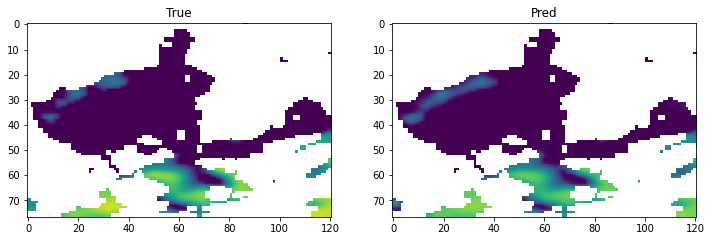

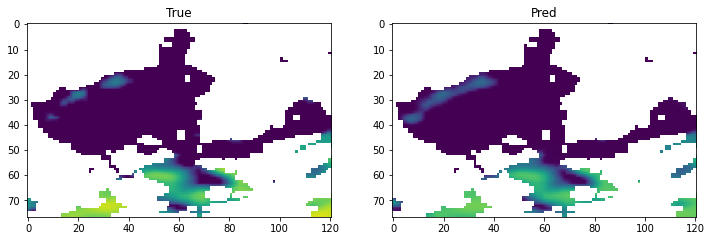

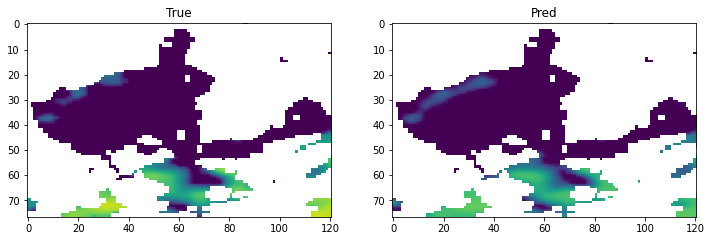

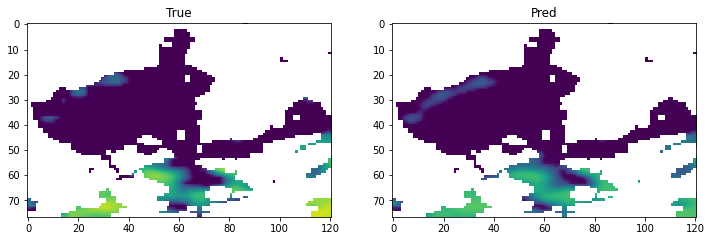

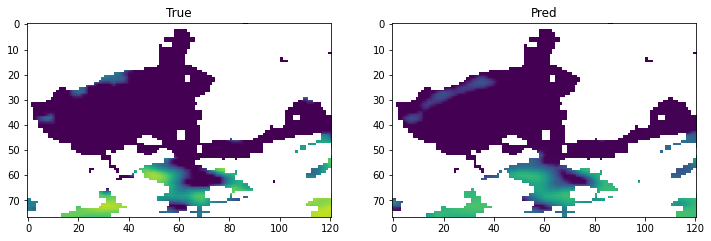

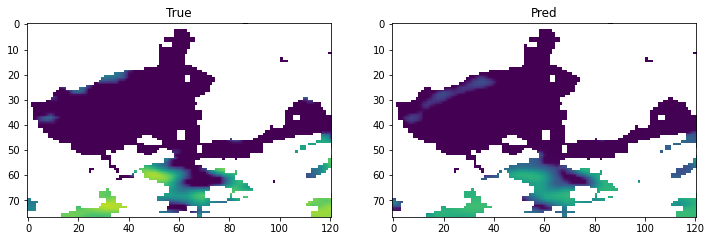

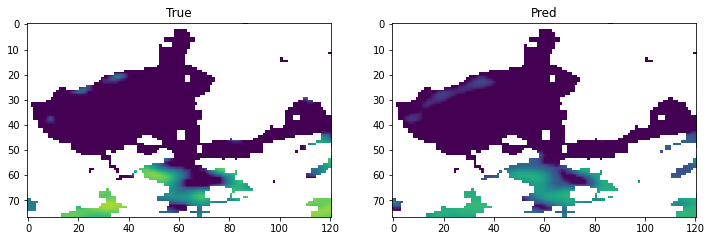

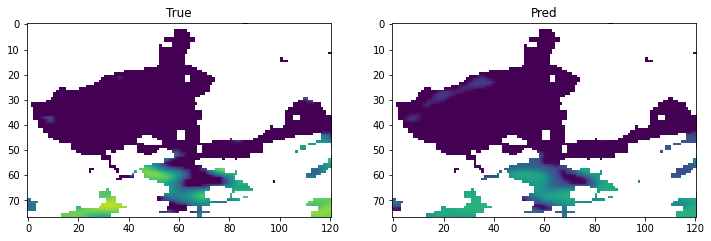

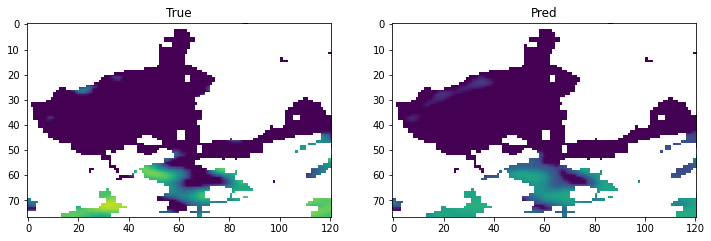

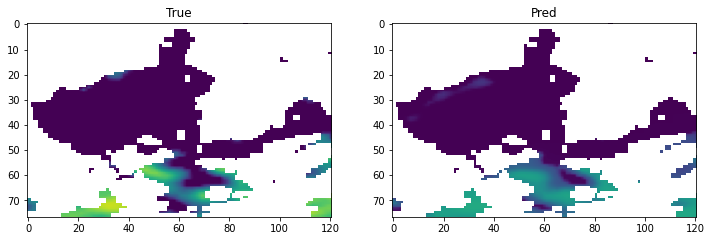

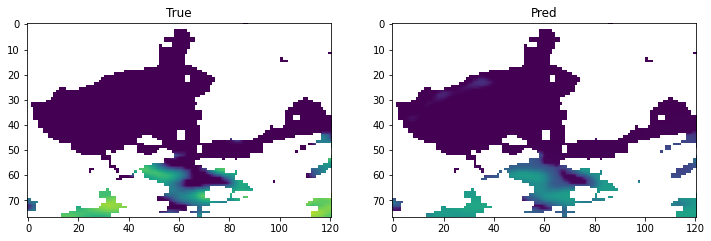

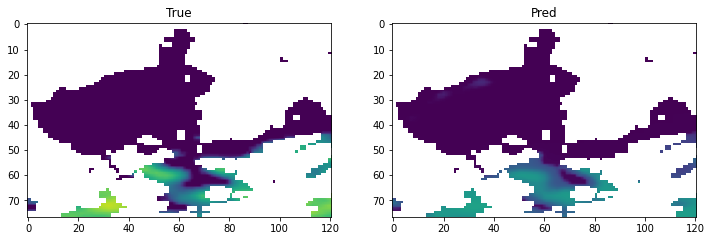

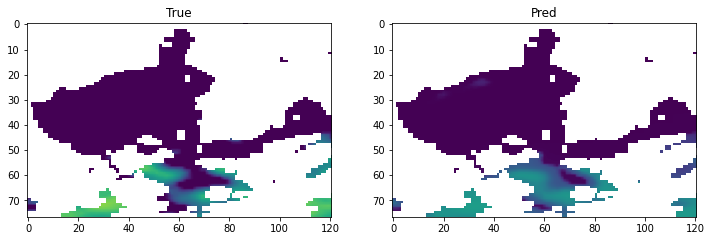

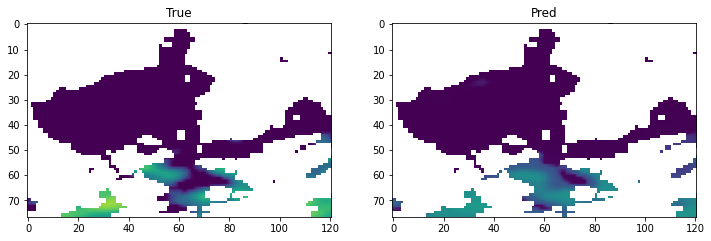

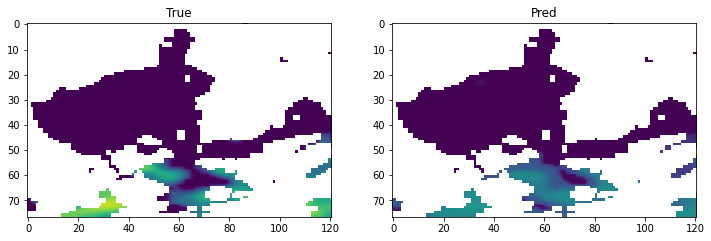

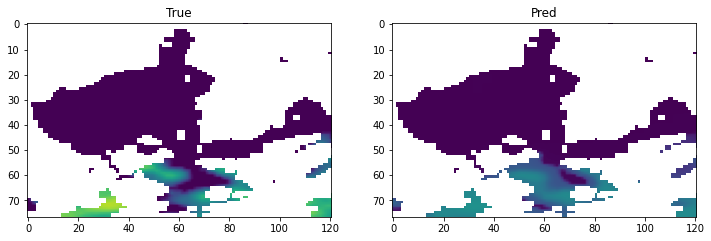

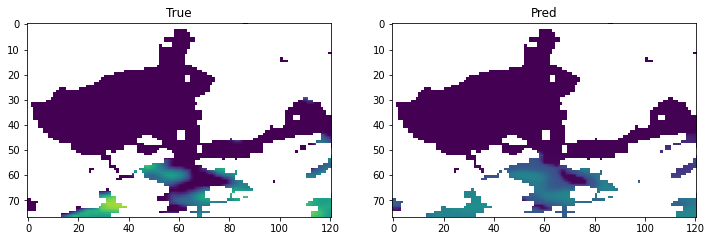

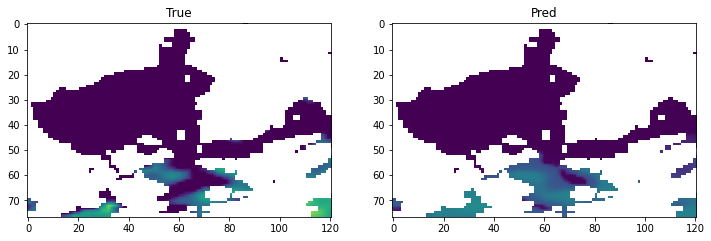

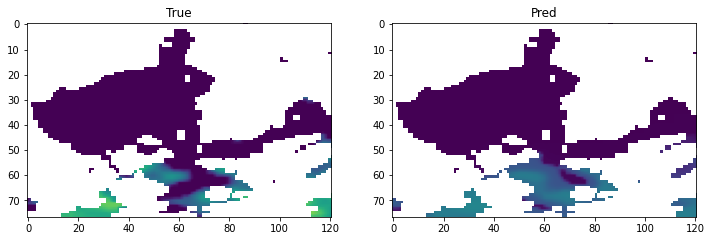

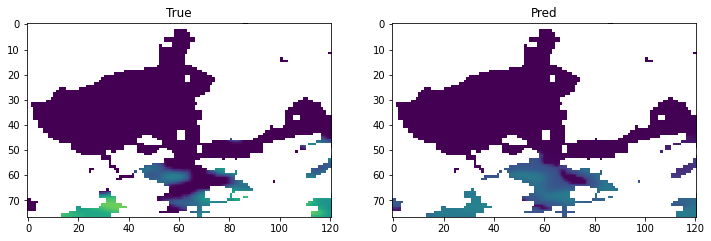

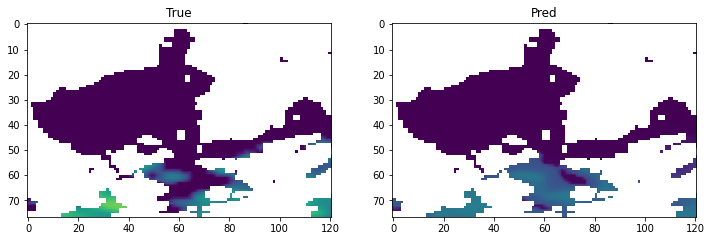

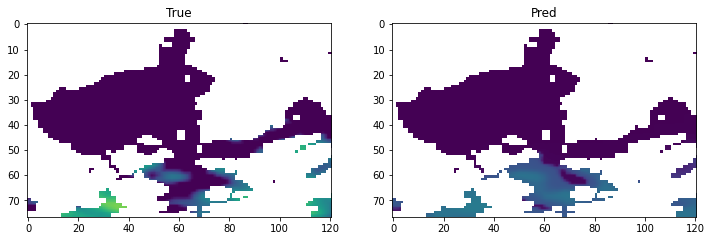

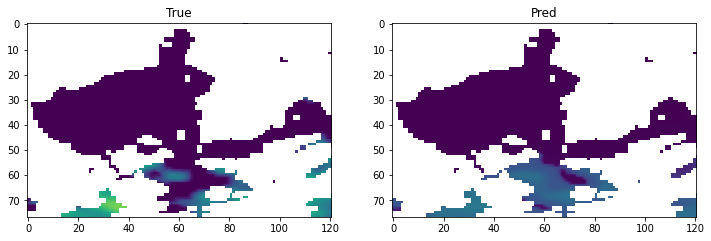

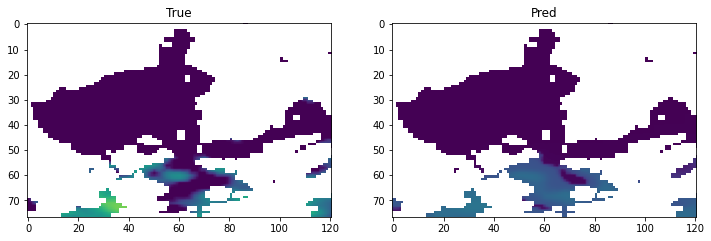

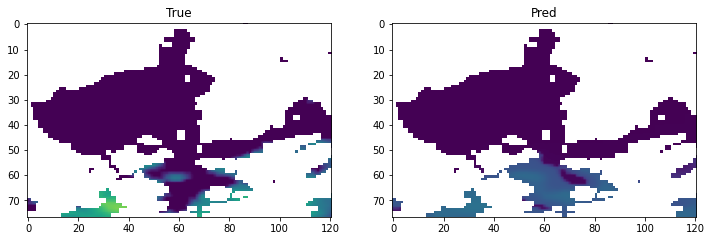

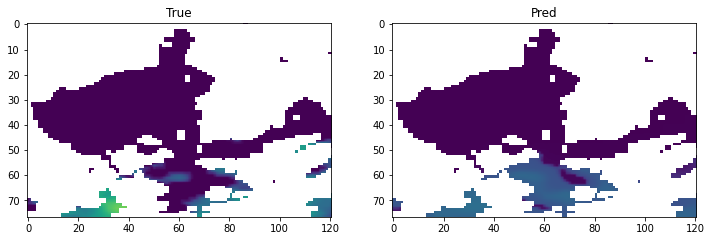

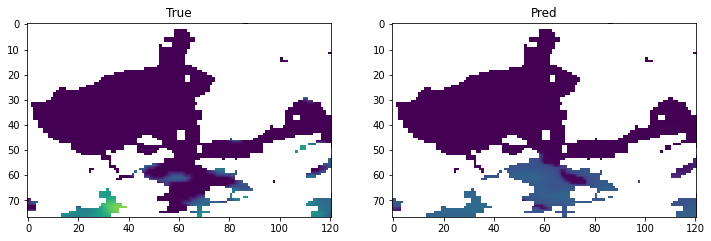

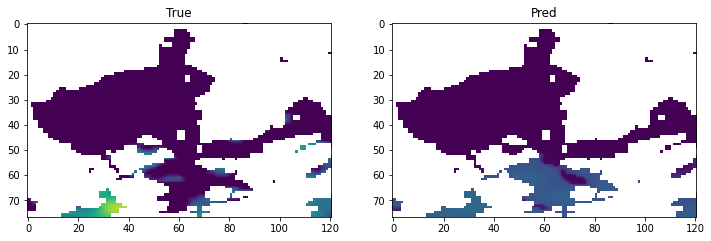

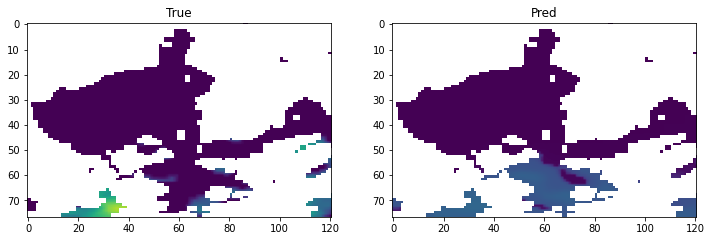

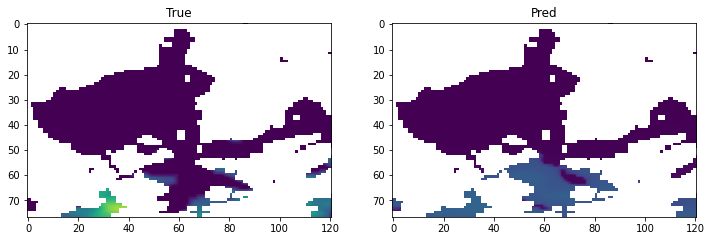

In [27]:
for i in range(ar_steps):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    y_val_step = y_viz[launch_step + i].squeeze(0)[..., 0]
    y_hat_step = y_hat.squeeze(0)[i][..., 0]
    axs[0].imshow(np.where(~mask, y_val_step, np.nan), vmin=0, vmax=1)
    axs[1].imshow(np.where(~mask, y_hat_step, np.nan), vmin=0, vmax=1)
    axs[0].set_title('True')
    axs[1].set_title('Pred')
    plt.show()

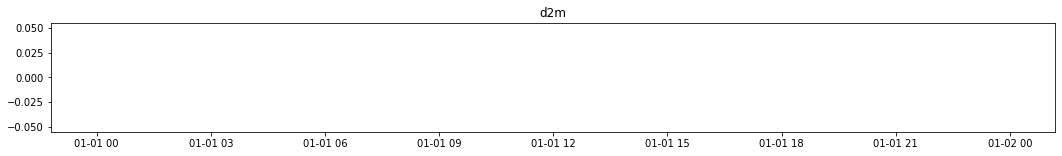

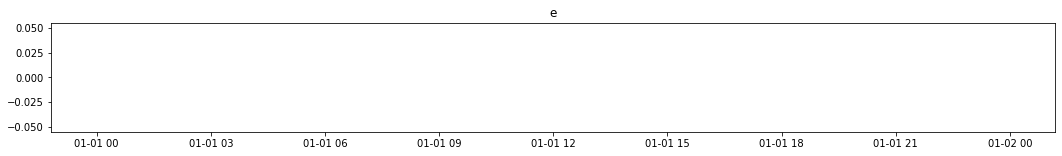

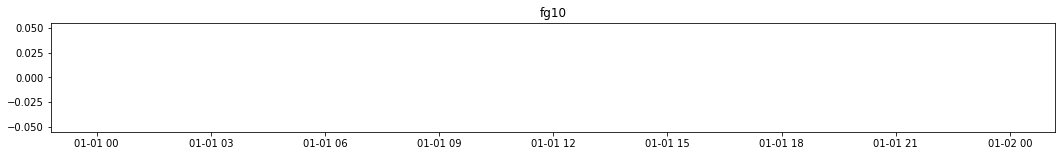

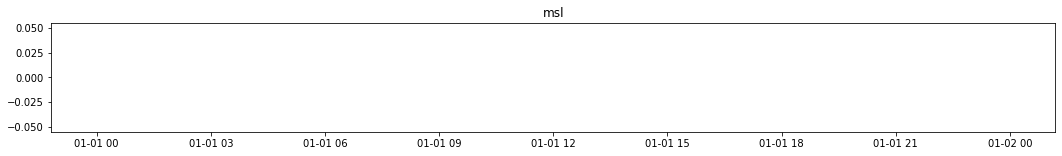

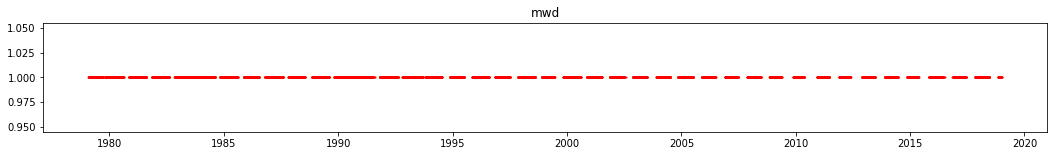

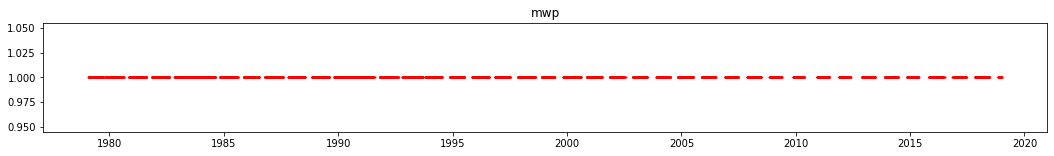

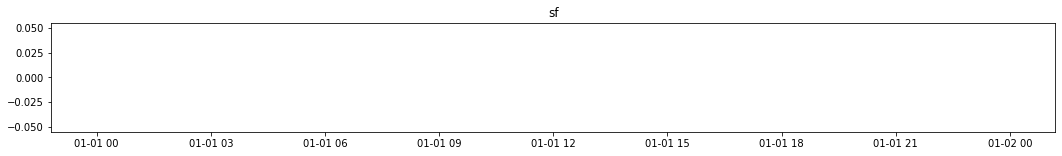

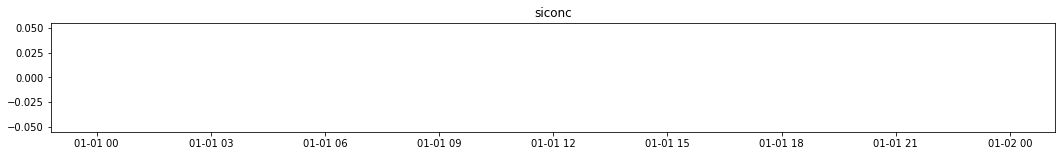

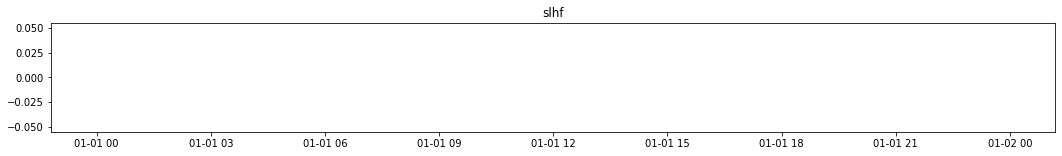

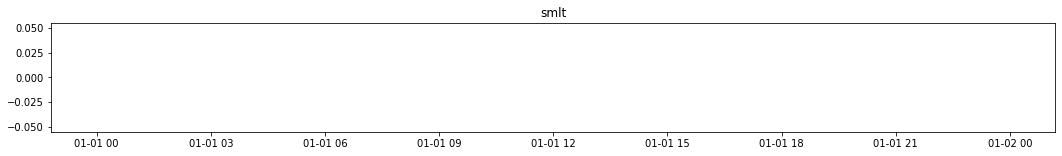

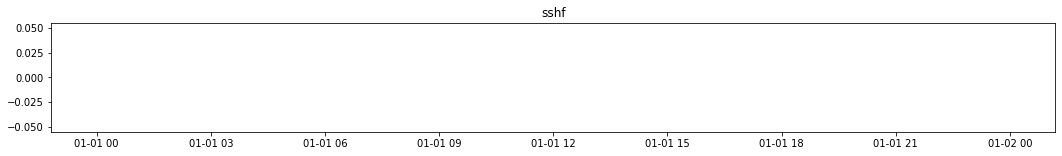

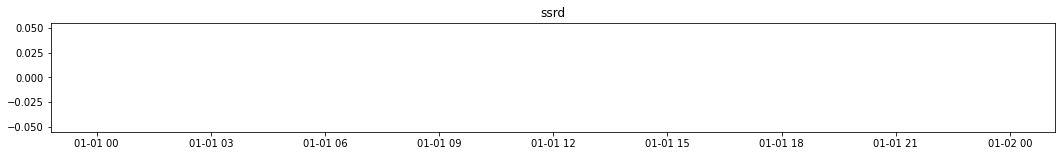

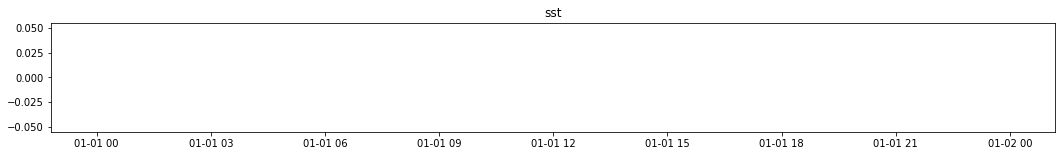

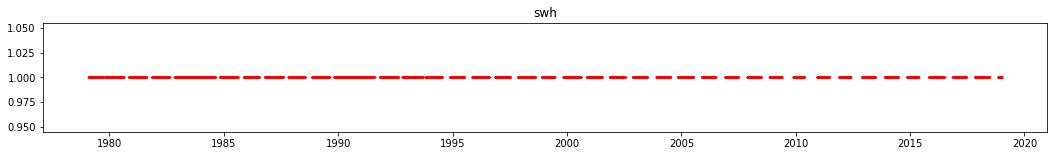

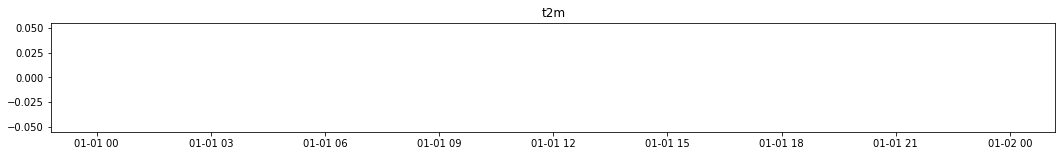

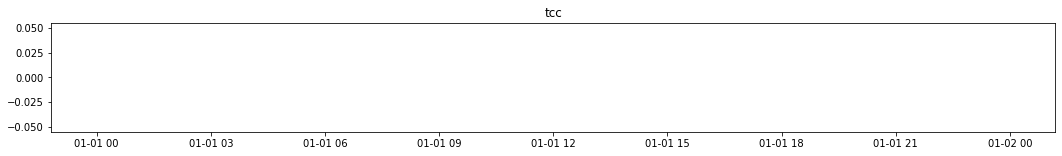

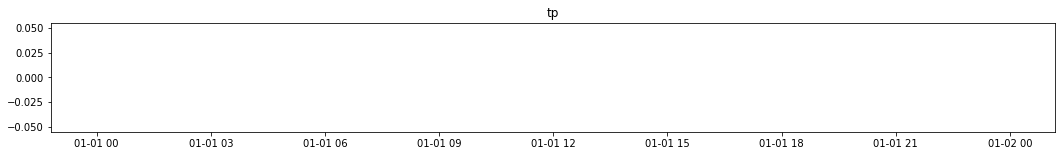

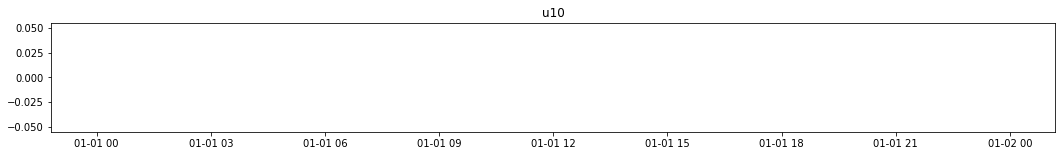

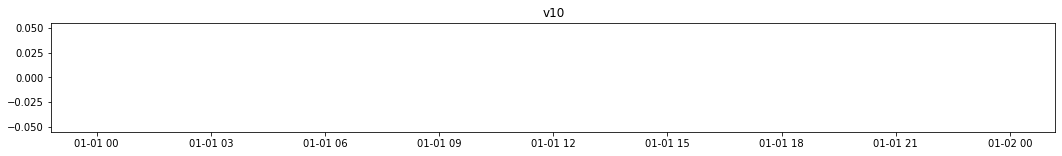

In [42]:
for d in ds.data_vars:
    plt.figure(figsize=(18, 2))
    plt.scatter(ds.time, np.where(np.isnan(ds.isel(latitude=50, longitude=50)[d]), 1, np.nan), c='r', s=1)
    plt.title(d)
    plt.show()